In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, \
    classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.simplefilter(action="ignore")

In [2]:
titanic = pd.read_csv("train.csv")
df = titanic.copy()


In [3]:
def info_(dataframe):
    print("Satır: {0}  Sutun: {1}".format(dataframe.shape[0],dataframe.shape[1]), "\n\n\n")
    print(dataframe.info(), "\n\n\n")
    print("Index:",dataframe.index, "\n\n\n")
    print("Columns:",dataframe.columns, "\n\n\n")
    print("ANY_NAN:",dataframe.isnull().values.any(), "\n\n\n")

In [4]:
info_(df)

Satır: 891  Sutun: 12 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None 



Index: RangeIndex(start=0, stop=891, step=1) 



Columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 



ANY_NAN: True 





In [5]:
def cat_summary(data):
    cat_cols = [col for col in data.columns if len(data[col].unique()) < 10]
    for col in cat_cols:
        print(pd.DataFrame({col:data[col].value_counts(),
                            "Ratio": 100 * data[col].value_counts() / len(data)}),end = "\n\n\n")
        sns.countplot(x = col,data = data)
        plt.show()
    
    print("Kategorik Değişken sayisi : {0}".format(len(cat_cols)))

   Survived      Ratio
0       549  61.616162
1       342  38.383838




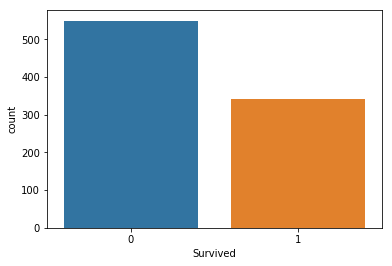

   Pclass      Ratio
3     491  55.106622
1     216  24.242424
2     184  20.650954




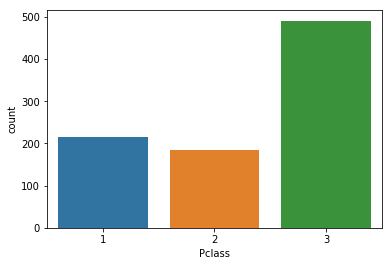

        Sex      Ratio
male    577  64.758698
female  314  35.241302




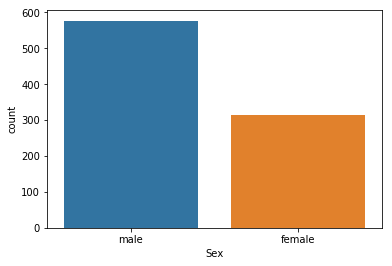

   SibSp      Ratio
0    608  68.237935
1    209  23.456790
2     28   3.142536
4     18   2.020202
3     16   1.795735
8      7   0.785634
5      5   0.561167




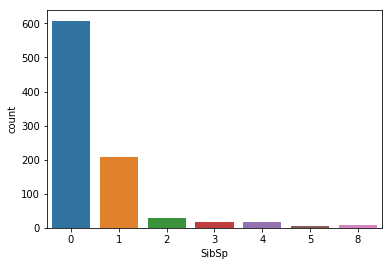

   Parch      Ratio
0    678  76.094276
1    118  13.243547
2     80   8.978676
5      5   0.561167
3      5   0.561167
4      4   0.448934
6      1   0.112233




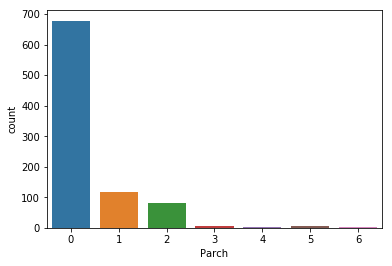

   Embarked      Ratio
S       644  72.278339
C       168  18.855219
Q        77   8.641975




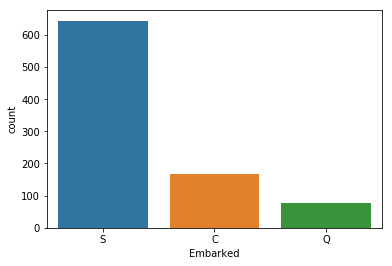

Kategorik Değişken sayisi : 6


In [6]:
# Kategorik değişkenlerimizin sınıf sayıları ve veri setinde yer alma oranları.
cat_summary(df)

In [7]:
def hist_of_num(data):
    num_cols = [col for col in data.columns if data[col].dtypes != "O" and col not in "PassengerId" and col not in "Survived" ]
    counting_col = 0
    for col in num_cols:
        data[col].hist()
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        counting_col += 1
        
    print("{0} sayıda histogram çizilmiştir.".format(counting_col))

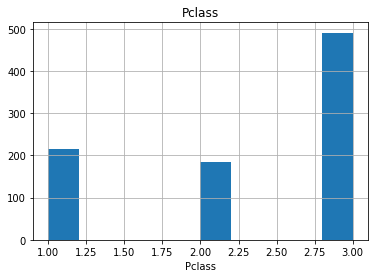

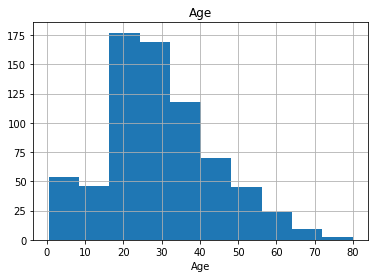

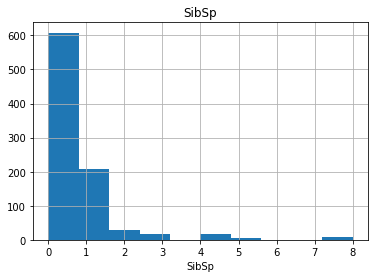

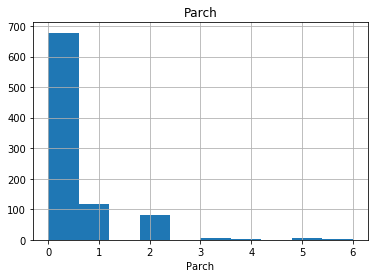

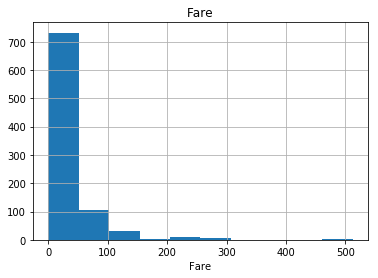

5 sayıda histogram çizilmiştir.


In [8]:
hist_of_num(df)

In [9]:
def outlier_thresholds(data,var):
    q1 = data[var].quantile(0.25)
    q3 = data[var].quantile(0.75)
    IQR = q3 - q1
    low_limit = q1 - IQR * 1.5
    up_limit = q3 + IQR * 1.5
    return (low_limit,up_limit)

In [10]:
num_cols = [col for col in df.columns if df[col].dtypes != "O" and len(df[col].unique()) > 10 and col not in "PassengerId" and col not in "Survived"]

In [11]:
def has_outliers(data,numeric_columns,plot = False):
    var_names = []
    
    for col in numeric_columns:
        low_limit,up_limit = outlier_thresholds(data,col)
        
        if data[(data[col] < low_limit) | (data[col] > up_limit)].any(axis = None):
            outlier_names = data[(data[col] < low_limit)  | (data[col] > up_limit)].shape[0]
            print(col,":",outlier_names)
            var_names.append(col)
            
        if plot:
            sns.boxplot(x = data[col])
            plt.show()
            
    return var_names

Age : 11


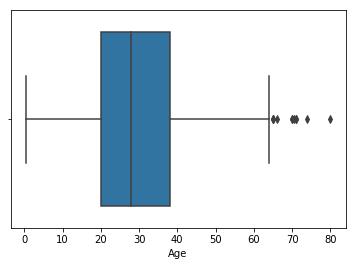

Fare : 116


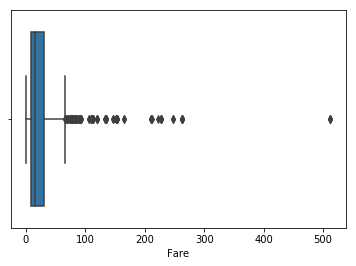

['Age', 'Fare']

In [12]:
has_outliers(df,num_cols,plot=True)

- Fare değişkeninde 116 , Age değişkeninde 11 aykırı değerimiz bulunuyor.

In [13]:
def replace_with_thresholds(data,var):
    low_limit,up_limit = outlier_thresholds(data,var)
    data.loc[(data[var] <low_limit), var] = low_limit
    data.loc[(data[var] > up_limit),var] = up_limit
    

In [15]:
# Aykırı değerleri yazdığımız fonksiyon ile baskılıyoruz
for col in num_cols:
    replace_with_thresholds(df,col)

In [16]:
df.describe([.01,.25,.50,.75,.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
PassengerId,891.0,446.000000,257.353842,1.00,9.9,223.5000,446.0000,668.5,882.1000,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0,0.0000,0.0000,1.0,1.0000,1.0000
Pclass,891.0,2.308642,0.836071,1.00,1.0,2.0000,3.0000,3.0,3.0000,3.0000
Age,714.0,29.622700,14.316665,0.42,1.0,20.1250,28.0000,38.0,64.8125,64.8125
SibSp,891.0,0.523008,1.102743,0.00,0.0,0.0000,0.0000,1.0,5.0000,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0,0.0000,0.0000,0.0,4.0000,6.0000
Fare,891.0,24.046813,20.481625,0.00,0.0,7.9104,14.4542,31.0,65.6344,65.6344


In [17]:
def missing_values(data):
    var_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[var_with_na].isnull().sum().sort_values(ascending = False)
    ratio = (data[var_with_na].isnull().sum() / len(data) * 100).sort_values(ascending= False)
    missing_df = pd.DataFrame({"n_miss":n_miss,
                               "Ratio": np.round(ratio, 2)})
    print(missing_df)
    
    return var_with_na

In [18]:
missing_values(df)

          n_miss  Ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


['Age', 'Cabin', 'Embarked']

In [19]:
cols_with_na = missing_values(df)

          n_miss  Ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


- Cabin değişkenin %77.10'u, Age değişkeninin %19.87'si ,Embarked değişkeninin %0.22'si eksik değerden oluşmakta.

In [20]:
# Çok fazla eksik değer olduğu için drop değişkenini düşürüyoruz.
df.drop("Cabin",axis = 1,
        inplace = True)

In [21]:
# Age değişkenini yaş ortalamasıyla, Embarked değişkenini ise mode ile atıyoruz.
df["Age"].fillna(df["Age"].mean(),
                 inplace = True)
df["Embarked"].fillna(df["Embarked"].mode()[0],inplace = True ) 

In [21]:
# Yaş değişkenini gruplandırarak Generation isminde yeni bir değişken yaratıyoruz.
df.loc[(df["Age"] < 18),"Generation"] = "Young"
df.loc[(df["Age"] >= 18) & (df["Age"] < 50),"Generation"] = "Mature"
df.loc[(df["Age"] >= 50),"Generation"] = "Older"

In [22]:
# Aile boyutu isimli bir değişken yaratarak SibSp ve Parch değişkenlerini verisetinden düşürüyoruz.
df["Family_size"] = df["SibSp"] + df["Parch"]
df.drop(["SibSp","Parch"],axis = 1,inplace = True)

In [23]:
def one_hot(data,category_freq = 10,nan_as_category = False):
    cat_cols = [col for col in data.columns if data[col].dtypes == "O" and len(data[col].unique()) <category_freq]
    
    for col in cat_cols:
        df = pd.get_dummies(data,columns = cat_cols,
                       drop_first = True)
        
        return df

In [24]:
df = one_hot(df)

In [25]:
df.head()

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,Family_size,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,1,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,65.6344,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,373450,8.0500,0,1,0,1


In [26]:
# Modelde kullanamayacağımız Name, Ticket ve PassengerId değişkenlerini modelden atıyoruz.
drop_list = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique())> 10]
df.drop(drop_list,axis = 1,
        inplace = True)
df.drop("PassengerId",axis = 1,
        inplace = True)

In [27]:
#Veri setimizin son hali.
df.head()

,Survived,Pclass,Age,Fare,Family_size,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,1,0,1
1,1,1,38.0,65.6344,1,0,0,0
2,1,3,26.0,7.9250,0,0,0,1
3,1,1,35.0,53.1000,1,0,0,1
4,0,3,35.0,8.0500,0,1,0,1


# Model

In [29]:
X = df.drop("Survived",axis = 1)
y = df["Survived"]


In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size = 0.20,
                                                 random_state = 42)

In [31]:
xgb_model = GradientBoostingClassifier()

In [32]:
xgb_model.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
y_pred = xgb_model.predict(X_test)

In [34]:
print(accuracy_score(y_test,y_pred))

0.8212290502793296


# Model Tuning

In [35]:
xgb_params = {"learning_rate": [0.1, 0.01, 0.5],
               "max_depth": [5, 8, 15, 20],
               "n_estimators": [100, 200, 500, 1000]}

In [36]:
xgb_model = GradientBoostingClassifier()

In [37]:
xgb_cv_model = GridSearchCV(xgb_model, 
                            xgb_params, 
                            cv=10, 
                            n_jobs=-1, 
                            verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.4min finished


In [41]:
xgb_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [42]:
xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_)

In [43]:
xgb_tuned.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [44]:
y_pred = xgb_tuned.predict(X_test)

In [50]:
print(accuracy_score(y_test,y_pred))

0.8156424581005587


In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       105
           1       0.85      0.68      0.75        74

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



In [51]:
# Modelin doğru tahminlerini ve yanlış tahminlerininin sayısını  görmek amacıyla karmaşıklık matrisini kullanalım
print(confusion_matrix(y_test,y_pred))

[[96  9]
 [24 50]]


- Tuned edilmiş modelimiz %81.56'lik bir başarı elde ederken. Tuned edilmemiş saf modelimizin başarı yüzdesi %82.12